# Overeating Classification – End-to-End Notebook (Sensor, EMA, XGBoost vs SVM vs NB)

This notebook trains and compares multiple classifiers (**XGBoost**, **SVM**, **Naive Bayes**) to predict **Overeating** from sensor- and/or EMA-derived features. It performs **5-fold stratified cross-validation**, handles **class imbalance** (SVMSMOTE), tunes XGBoost via **Bayesian Optimization**, and visualizes **ROC**, **Precision–Recall**, and **Calibration** (Brier score). Figures are saved to `./result/`.

---

## What this notebook does

- Load two CSVs:
  - `SenseWhy_sensor_features.csv` → sensor + contextual fields (and the label `Overeating`)
  - `SenseWhy_EMA_features.csv` → EMA fields (and the label `Overeating`)
- Engineer composite context features (e.g., **Self-prepared meal**, **Restaurant-sourced meal**, **Social dining experiences**), **bite_chew_ratio** (chews/bite), and **Night Eating** flags.
- Standardize numeric features (z-score).
- Cross-validate models with threshold search for best **F1** per fold.
- Plot and save:
  - ROC curves (AUROC ± SD)
  - Precision-Recall curves (AUPRC ± SD + baseline prevalence)
  - Calibration curves with **Brier score** (mean ± SD)
- Compare **XGBoost vs SVM vs Naive Bayes** head-to-head.

---

## File expectations

Place these files in the working directory:
- `SenseWhy_sensor_features.csv`
- `SenseWhy_EMA_features.csv`

> The code assumes both files contain a binary column **`Overeating`** (0/1). 

---

## How to run (quick start)

1. (Optional) Install dependencies:

    ```bash
    pip install numpy pandas matplotlib scikit-learn xgboost imbalanced-learn bayesian-optimization shap
    ```

2. Open this notebook and **run cells top-to-bottom**:
   - Choose your **subset** in the “Load Data & Choose Feature Subset” cell:
     - `subset_index = 0` → sensor only  
     - `subset_index = 1` → EMA only  
     - `subset_index = 2` → both (sensor + any EMA/demo columns present)  
   - Let it train, evaluate, and **save plots** into `./result/`.

---

## Function map (what each block does)

- **`to_labels(pos_probs, threshold)`**  
  Convert positive-class probabilities to binary labels.

- **`sensor_feature_preprocess(df)`**  
  Build composite context features; compute `bite_chew_ratio`; derive `Night Eating`; drop raw identifier/context columns.

- **`EMA_feature_preprocess(df)`**  
  Select EMA-related columns; build composite context features; drop raw context columns.

- **`get_train_data(df, cols, label='Overeating')`**  
  Subset features + label, **standardize** features, return `X, y`.

- **`xgb_evaluate(...)`**  
  Score a single XGBoost hyperparameter configuration via **5-fold CV** using **F1**.

- **`optimize_xgb(X, y, params)` / `xgb_optimize(...)`**  
  **Bayesian Optimization** loop to find best XGBoost hyperparameters (optionally save JSON).

- **`model_evaluation(X, y, model, optimization, validation, ...)`**  
  5-fold CV with optional **SMOTE** balancing and **in-fold** XGBoost tuning; returns aggregates for ROC, PR, Calibration, and Brier score.

> Plots are produced in dedicated cells, both for **validation vs. test** (XGBoost) and **model comparison** (XGBoost vs SVM vs NB).

---

## Toggle points you can customize

- **Subset selection**: `subset_index = 0|1|2`
- **SVM GridSearch**: adjust `svc_param_grid` (C, kernel, gamma).
- **XGBoost bounds**: edit `params` in `model_evaluation` → `xgb_optimize(...)`.
- **Imbalance handling**: switch `SVMSMOTE` to `SMOTE`, `BorderlineSMOTE`, etc.
- **Thresholding**: F1-optimal threshold is chosen per fold; adjust resolution via `np.arange(0,1,0.001)`.

---

## Outputs

Saved to `./result/`:
- `val_test_both.png/.pdf` (XGBoost validation vs test curves)
- `xg_stats_both.png/.pdf` (XGBoost vs SVM vs NB comparison)

> Filenames reflect the selected subset; update as needed in plotting cells.

---

## Reproducibility

- Global random seed: `RANDOM_STATE = 42`
- `StratifiedKFold(..., shuffle=True, random_state=42)`
- SVM/XGBoost use `random_state=42` where supported.

---

## Tips

- If a column listed in preprocessing is **missing** from your CSVs, consider adding safe access via `df.get(col, 0)` or remove it from the lists.  

---

*Run the next cell to import packages and create result folders, then proceed.*


In [1]:
#import the necessary packages
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import f1_score, make_scorer
from bayes_opt import BayesianOptimization
import shap
import scipy.stats as stats
import numpy as np
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SVMSMOTE, KMeansSMOTE
from sklearn.calibration import calibration_curve
from sklearn.utils import class_weight    
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, brier_score_loss
from scipy import interp    
import matplotlib.pyplot as plt    
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVC
import json
import warnings
warnings.filterwarnings("ignore")
RANDOM_STATE = 42

C:\Users\farza\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\farza\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\farza\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
C:\Users\farza\anaconda3\lib\site-packages\xgboost\compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\farza\anaconda3\lib\site-packages\dask\dataframe\utils.py:369: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
C:\Users\farza\anaconda3\lib\site-packages\dask\

In [2]:
# Helper: Convert probability outputs to binary labels using a given threshold.
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')  

In [3]:
# Preprocess sensor features: build composite context variables, calculate eating quality, create Night Eating flag, drop redundant/raw columns.
def sensor_feature_preprocess(df_all_final):
    df_all_final['Self-prepared meal'] = df_all_final['Cooked by me from ingredient delivery service'] | df_all_final['Cooked by me from scratch'] | df_all_final['Cooked by me from frozen/prepackaged meal']
    df_all_final['Restaurant-sourced meal'] = df_all_final['Bought from restaurant – Dine in'] | df_all_final['Bought from restaurant – Takeout'] | df_all_final['Delivery']
    df_all_final['Light refreshment'] = df_all_final['Snacks/Cereal'] | df_all_final['No food, just beverage'] 
    df_all_final['Focused dining'] = df_all_final['Nothing else']
    df_all_final['Task-oriented distractions'] = df_all_final['Watching TV'] | df_all_final['Working/studying']| df_all_final['Driving'] 
    df_all_final['Solo dining'] = df_all_final['I ate by myself']
    df_all_final['Social dining experiences'] = df_all_final['In-person with family/friends'] | df_all_final['Virtually with friends/family'] | df_all_final['With acquaintances/friends'] 
    df_all_final['In-home dining'] = df_all_final['home'] 
    df_all_final['In-resturant dining'] = df_all_final['restaurant'] 
    df_all_final['work/school dining'] = df_all_final['work'] |  df_all_final['school']
    df_all_final = df_all_final.drop(columns=['Cooked by me from ingredient delivery service','Cooked by me from scratch','Cooked by me from frozen/prepackaged meal','Snacks/Cereal','No food, just beverage',
    'Nothing else', 'Watching TV','Working/studying','Driving' ,'I ate by myself', 'In-person with family/friends','Virtually with friends/family','With acquaintances/friends',
    'home',  'restaurant', 'work','school','Bought from restaurant – Dine in','Bought from restaurant – Takeout','Delivery', 'other'])                   
    df_all_final['bite_chew_ratio'] = np.where(df_all_final['num_bites'] ==0, 0, df_all_final['num_chews']/df_all_final['num_bites'])
    df_all_final['bite_chew_ratio'] = pd.to_numeric(df_all_final['bite_chew_ratio'])
    df_all_final['Date/Time of Meal'] = pd.to_datetime(df_all_final['Date/Time of Meal'], format = '%Y-%m-%d')
    df_all_final['Night Eating'] = df_all_final['Date/Time of Meal'].dt.hour.between(6, 17, inclusive=True).replace({True: 0, False: 1})
    df_all_final = df_all_final.drop(columns=['ID', 'Start', 'End','Date/Time of Meal','BMI', 'Age'])
    return df_all_final

In [4]:
# Preprocess EMA features: select EMA-related columns, engineer composite features (e.g., self-prepared meal, restaurant-sourced meal, social dining), drop raw context columns.
def EMA_feature_preprocess(df_all_final):
    ema_features = ['before_stress', 'before_emotion_lonely', 'before_emotion_upbeat',
                    'before_emotion_calm', 'before_absence_of_hunger',
                    'before_hedonic_eating', 'before_biological_hunger',
                    'after_cognitive_restraint', 'after_uncontrolled_eating',
                    'after_overeating', 'after_hedonic_eating', 'after_stress', 'Night Eating',
                    'Cooked by me from scratch',
                    'Cooked by me from ingredient delivery service',
                    'Cooked by me from frozen/prepackaged meal',
                    'Bought from restaurant – Dine in', 'Bought from restaurant – Takeout',
                    'Delivery', 'Snacks/Cereal', 'No food, just beverage',
                    'I ate by myself', 'In-person with family/friends',
                    'Virtually with friends/family', 'With acquaintances/friends', 'work',
                    'school', 'home', 'restaurant', 'other', 'Nothing else',
                    'Working/studying', 'Watching TV', 'Driving', 'Socializing','Overeating']
    demo_features = ['Age','BMI', 'BMI_category', 'Sex', 'Race', 'Ethnicity']
    label = 'Overeating'
    df_all_final = df_all_final[ema_features]
    df_all_final['Self-prepared meal'] = df_all_final['Cooked by me from ingredient delivery service'] | df_all_final['Cooked by me from scratch'] | df_all_final['Cooked by me from frozen/prepackaged meal']
    df_all_final['Restaurant-sourced meal'] = df_all_final['Bought from restaurant – Dine in'] | df_all_final['Bought from restaurant – Takeout'] | df_all_final['Delivery']
    df_all_final['Light refreshment'] = df_all_final['Snacks/Cereal'] | df_all_final['No food, just beverage'] 
    df_all_final['Focused dining'] = df_all_final['Nothing else']
    df_all_final['Task-oriented distractions'] = df_all_final['Watching TV'] | df_all_final['Working/studying']| df_all_final['Driving'] 
    df_all_final['Solo dining'] = df_all_final['I ate by myself']
    df_all_final['Social dining experiences'] = df_all_final['In-person with family/friends'] | df_all_final['Virtually with friends/family'] | df_all_final['With acquaintances/friends'] 
    df_all_final['In-home dining'] = df_all_final['home'] 
    df_all_final['In-resturant dining'] = df_all_final['restaurant'] 
    df_all_final['work/school dining'] = df_all_final['work'] |  df_all_final['school']
    df_all_final = df_all_final.drop(columns=['Cooked by me from ingredient delivery service','Cooked by me from scratch','Cooked by me from frozen/prepackaged meal','Snacks/Cereal','No food, just beverage',
    'Nothing else', 'Watching TV','Working/studying','Driving' ,'I ate by myself', 'In-person with family/friends','Virtually with friends/family','With acquaintances/friends',
    'home',  'restaurant', 'work','school','Bought from restaurant – Dine in','Bought from restaurant – Takeout','Delivery', 'other'])    
    return df_all_final


In [5]:
# Prepare X (features) and y (labels): subset columns, scale numerical features using StandardScaler.
def get_train_data(df, cols, label='Overeating'):
    # get features and label
    df = df[cols+[label]]
    X_CV, y_CV = df.drop(columns=[label]).reset_index(drop = True), df[label].reset_index(drop = True)
    
    # standardize features by removing the mean and scaling to unit variance
    scl = StandardScaler()
    numerical_data = X_CV[cols]
    scaled_numerical_data = pd.DataFrame(scl.fit_transform(numerical_data))
    X_CV[cols] = scaled_numerical_data
    return(X_CV, y_CV)

In [6]:
# wrapper function for XGBoost optimization
def optimize_xgb(X, y, params):
    def xgb_evaluate_wrapper(max_depth, learning_rate, n_estimators, gamma, max_delta_step, subsample, colsample_bytree):
        return xgb_evaluate(X, y, max_depth, learning_rate, n_estimators, gamma, max_delta_step, subsample, colsample_bytree)
    
    optimizer = BayesianOptimization(f=xgb_evaluate_wrapper, pbounds=params, verbose=0, random_state=RANDOM_STATE)
    optimizer.maximize(init_points=5, n_iter=25)
    
    return optimizer

In [7]:
# XGBoost optimization on Stratified K Fold CV
def xgb_evaluate(X, y, max_depth, learning_rate, n_estimators, gamma, max_delta_step, subsample, colsample_bytree):
    params = {
        'max_depth': int(round(max_depth)),
        'learning_rate': learning_rate,
        'n_estimators': int(round(n_estimators)),
        'gamma': gamma,
        'max_delta_step': max_delta_step,
        'subsample': subsample,
        'colsample_bytree': colsample_bytree
    }
    
    model = xgb.XGBClassifier(**params)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    f1_scorer = make_scorer(f1_score)
    scores = cross_val_score(model, X, y, scoring=f1_scorer, cv=cv) # X,y refers to train+val set
    return scores.mean()

In [8]:
# XGBoost optimization main function
def xgb_optimize(X, y, params, save=False, dir='model/best_xgb_params.json'):
    optimizer = optimize_xgb(X, y, params)
    
    # Train and evaluate the model with the best parameters
    best_params = optimizer.max['params']
    best_params['max_depth'] = int(round(best_params['max_depth']))
    best_params['n_estimators'] = int(round(best_params['n_estimators']))
    model = xgb.XGBClassifier(**best_params, eval_metric='aucpr',scale_pos_weight=(len(y) - sum(y)) / sum(y))
    if(save==True):
        with open(dir, 'w') as f:
            json.dump(best_params, f)
        print("Best parameters saved to", dir)
    return(best_params)

In [9]:
# Cross-validated evaluation: perform 5-fold CV with optional optimization (using SMOTE balancing), calculate ROC, PR, calibration, and Brier score.
def model_evaluation(X, y, model, optimization = True, validation=False, verbose=False, save=False, dir='model/best_xgb_params.json'):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
      
    f1_score_final = []
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    precisions = []
    ap_scores = []
    mean_recall = np.linspace(0, 1, 100)
    mean_predicted_value_list = []
    fraction_of_positives_list = []
    clf_score = []
    
    for fold, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        #print('fold:', fold+1)
        # Splitting data into training and validation sets
        X_train_all, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train_all, y_test = y[train_idx], y[test_idx]
        X_train, X_val, y_train, y_val = train_test_split(X_train_all, y_train_all, test_size=0.25, random_state=RANDOM_STATE)
    
        #print(X_train.shape, X_val.shape, X_test.shape)

        if(optimization == True):
            smote = SVMSMOTE(random_state=RANDOM_STATE)
        
            if(validation == True):
                X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
            else:
                X_train_balanced, y_train_balanced = smote.fit_resample(X_train_all, y_train_all)
                X_val = X_test
                y_val = y_test
                
            X_train, y_train = X_train_balanced, y_train_balanced

            dir = 'model/best_xgb_params' + '_fold_' + str(fold+1) + '.json'
            params = params = {'max_depth': (3, 20),
                               'learning_rate': (0.01, 0.3),
                               'n_estimators': (10, 200),
                               'gamma': (0, 5),
                               'max_delta_step': (0, 10),
                               'subsample': (0.5, 1),
                               'colsample_bytree': (0.5, 1)
                              }
            best_params = xgb_optimize(X_train, y_train, params, save=save, dir=dir)
            model = xgb.XGBClassifier(**best_params, eval_metric='aucpr',scale_pos_weight=(len(y) - sum(y)) / sum(y))
            
        
        model.fit(X_train, y_train)
            
        yhat = model.predict_proba(X_val)
        # keep probabilities for the positive outcome only
        probs = yhat[:, 1]
        # define thresholds
        thresholds = np.arange(0, 1, 0.001)
        # evaluate each threshold
        scores = [f1_score(y_val, to_labels(probs, t)) for t in thresholds]
        scores_weighted = [f1_score(y_val, to_labels(probs, t), average = 'weighted') for t in thresholds]
        # get best threshold
        ix = np.argmax(scores)
    
        if(verbose):
            print('Threshold=%.3f, F-Score weighted=%.5f' % (thresholds[ix], scores_weighted[ix]))
            
        f1_score_final.append(scores[ix])
        y_score = model.predict_proba(X_val)[:, 1]
        fpr, tpr, _ = roc_curve(y_val, y_score)
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        
        # Precision-Recall
        precision, recall, _ = precision_recall_curve(y_val, y_score,sample_weight=class_weight.compute_sample_weight('balanced', y_val))
        precisions.append(interp(mean_recall, recall[::-1], precision[::-1]))
        ap_score = average_precision_score(y_val, y_score, sample_weight=class_weight.compute_sample_weight('balanced', y_val))
        ap_scores.append(ap_score)
        
        fraction_of_positives, mean_predicted_value = calibration_curve(y_val, y_score, n_bins=10, strategy='quantile')
        mean_predicted_value_list.append(mean_predicted_value)
        fraction_of_positives_list.append(fraction_of_positives)
        clf_score.append(brier_score_loss(y_val, y_score))
        
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    
    mean_precision = np.mean(precisions, axis=0)
    mean_ap = np.mean(ap_scores)
    std_ap = np.std(ap_scores)
    brier_score = np.mean(clf_score)
    brier_score_std = np.std(clf_score)
    return(mean_fpr, mean_tpr, mean_auc, std_auc, mean_recall, mean_precision, mean_ap, std_ap, mean_predicted_value_list, fraction_of_positives_list, brier_score, brier_score_std)


In [10]:
#Main driver: load data, preprocess depending on subset (sensor / EMA / both), train and evaluate models (SVM, NB, XGBoost), visualize ROC, PR, Calibration.
def main(subset_index):
	# read the dataset
    df_all_features = pd.read_csv('SenseWhy_sensor_features.csv')
    df_EMA_features = pd.read_csv('SenseWhy_EMA_features.csv')
   
   	# select subset <- change for sensor/EMA/both combined 
    # Which subset to run: 0='sensor', 1='EMA', 2='both'
    subset = ['sensor', 'EMA', 'both']
    target = subset[subset_index] # default:sensor
    visualize = True # visualize resulrs
   
    print('Processing:', target)
   
   	# sensor_only features
    numerical_cols_sensor = ['meal_duration', 'num_bites', 'speed_bites', 'interval_bites',
   	                         'num_chews', 'speed_chews', 'interval_chews', 'bite_chew_ratio']  
   	# EMA_only features
    numerical_cols_EMA = ['before_stress', 'before_emotion_lonely', 'before_emotion_upbeat',
   	                      'before_emotion_calm', 'before_absence_of_hunger',
   	                      'before_hedonic_eating', 'before_biological_hunger',
   	                      'after_cognitive_restraint', 'after_uncontrolled_eating',
   	                      'after_overeating', 'after_hedonic_eating', 'after_stress',
   	                      'Night Eating', 'Socializing', 'Self-prepared meal',
   	                      'Restaurant-sourced meal', 'Light refreshment', 'Focused dining',
   	                      'Task-oriented distractions', 'Solo dining',
   	                      'Social dining experiences', 'In-home dining', 'In-resturant dining',
   	                      'work/school dining']

   
   	# sensor only
    if (target == 'sensor'):
   	    # preprocess data
   	    df_all_final = sensor_feature_preprocess(df_all_features)
   	    X_all, y_all = get_train_data(df_all_final, numerical_cols_sensor, label='Overeating')
    elif(target == 'EMA'):
   	    # preprocess data
   	    df_all_final = EMA_feature_preprocess(df_EMA_features)
   	    X_all, y_all = get_train_data(df_all_final, numerical_cols_EMA, label='Overeating')
    else:
   	    df_all_final = sensor_feature_preprocess(df_all_features)
   	    numerical_cols_both = numerical_cols_sensor + numerical_cols_EMA 
   	    X_all, y_all = get_train_data(df_all_final, numerical_cols_both, label='Overeating')


	# train + evluation
    #print("\nOptimizing SVC Parameters...")
    svc_param_grid = {
        'C': [0.1, 1, 10, 100],
        'kernel': ['linear', 'rbf', 'poly'],
        'gamma': [1, 0.1, 0.01, 0.001],
    }
    grid_svc = GridSearchCV(SVC(probability=True, random_state=RANDOM_STATE), svc_param_grid, scoring='f1', cv=5, n_jobs = -1, verbose=2)
    grid_svc.fit(X_all, y_all)

#    Best parameters
    best_svc_params = grid_svc.best_params_
    #print(f"Best SVC Parameters: {best_svc_params}")
    

    # Train with best parameters
    model_SVC = SVC(probability=True, random_state=RANDOM_STATE, **best_svc_params)
    mean_fpr_SVC, mean_tpr_SVC, mean_auc_SVC, std_auc_SVC, mean_recall_SVC, mean_precision_SVC, mean_ap_SVC, std_ap_SVC, mpv_l_SVC, fp_l_SVC, brier_score_SVC, brier_score_std_SVC = model_evaluation(
        X_all, y_all, model_SVC, optimization=False, validation=True, verbose=False, save=False)




	# naive bayes
    model_nb = GaussianNB()
    
    mean_fpr_nb, mean_tpr_nb, mean_auc_nb, std_auc_nb, mean_recall_nb, mean_precision_nb, mean_ap_nb, std_ap_nb, mpv_l_nb, fp_l_nb, brier_score_nb, brier_score_std_nb  = model_evaluation(X_all, y_all, model_nb, optimization = False, validation=True, verbose=False, save=False)

    X, y = X_all, y_all
	# XGBoost
    model_xgb = xgb.XGBClassifier(eval_metric='aucpr',scale_pos_weight=(len(y) - sum(y)) / sum(y))
    mean_fpr, mean_tpr, mean_auc, std_auc, mean_recall, mean_precision, mean_ap, std_ap, mpv_l, fp_l, brier_score, brier_score_std  = model_evaluation(X_all, y_all, model_xgb, optimization = True, validation=False, verbose=False, save=False)
    mean_fpr_v, mean_tpr_v, mean_auc_v, std_auc_v, mean_recall_v, mean_precision_v, mean_ap_v, std_ap_v, mpv_l_v, fp_l_v, brier_score_v, brier_score_std_v = model_evaluation(X_all, y_all, model_xgb, optimization = True, validation=True, verbose=False, save=False)

    if(visualize):
        # visualization (validation vs testing)
        # ROC Curve
            plt.figure(figsize=(12, 4))
            plt.subplot(1, 3, 1)
            plt.plot(mean_fpr, mean_tpr, color='blue', label=r'XGBoost - test (AUROC = %0.2f $\pm$ %0.2f)' % (mean_auc , std_auc))
            plt.plot(mean_fpr_v, mean_tpr_v, color='red', label=r'XGBoost - val (AUROC = %0.2f $\pm$ %0.2f)' % (mean_auc_v , std_auc_v))
            plt.fill_between(mean_fpr, mean_tpr - std_auc, mean_tpr + std_auc, color='blue', alpha=0.2)
            plt.fill_between(mean_fpr_v, mean_tpr_v - std_auc_v, mean_tpr_v + std_auc_v, color='red', alpha=0.2)
            plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier')
            plt.gca().set_ylim([-0,1])
            plt.gca().set_xlim([-0,1])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('ROC Curve')
            plt.legend(loc="lower right", fontsize = 8)

		# Precision-Recall Curve
            plt.subplot(1, 3, 2)
            plt.plot(mean_recall, mean_precision, color='blue', label=r'XGBoost - test (AUPRC = %0.2f $\pm$ %0.2f)' % (mean_ap, std_ap))
            plt.fill_between(mean_recall, mean_precision - std_ap, mean_precision + std_ap, color='blue', alpha=0.2)
            plt.plot(mean_recall_v, mean_precision_v, color='red', label=r'XGBoost - val (AUPRC = %0.2f $\pm$ %0.2f)' % (mean_ap_v, std_ap_v))
            plt.fill_between(mean_recall_v, mean_precision_v - std_ap_v, mean_precision_v + std_ap_v, color='red', alpha=0.2)
            plt.plot([0, 1], [sum(y)/len(y), sum(y)/len(y)], linestyle='--', label='Random Classifier')
            plt.gca().set_ylim([-0,1])
            plt.gca().set_xlim([-0,1])
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.title('Precision-Recall Curve')
            plt.legend(loc="lower right", fontsize = 8)

		# Calibration curve
            plt.subplot(1, 3, 3)
            plt.plot(np.mean(mpv_l, axis =0), np.mean(fp_l, axis =0), color='blue', markersize = 4, marker='o', linestyle='-', label='XGBoost - test (Brier score loss = %0.2f $\pm$ %0.2f)' % (brier_score, brier_score_std))
            plt.fill_between(np.mean(mpv_l, axis =0), np.mean(fp_l, axis =0) - np.std(fp_l, axis =0), np.mean(fp_l, axis =0) + np.std(fp_l, axis =0), color='blue', alpha=0.2)
            plt.plot(np.mean(mpv_l_v, axis =0), np.mean(fp_l_v, axis =0), color = 'red', markersize = 4, marker='o', linestyle='-', label='XGBoost - val (Brier score loss = %0.2f $\pm$ %0.2f)' % (brier_score_v, brier_score_std_v))
            plt.fill_between(np.mean(mpv_l_v, axis =0), np.mean(fp_l_v, axis =0) - np.std(fp_l_v, axis =0), np.mean(fp_l_v, axis =0) + np.std(fp_l_v, axis =0), color='red', alpha=0.2)
            plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
            plt.gca().set_ylim([-0,1])
            plt.gca().set_xlim([-0,1])
            plt.xlabel('Mean predicted value')
            plt.ylabel('Fraction of positives')
            plt.title('Calibration Curve')
            plt.legend(loc='best', fontsize = 8)
            plt.tight_layout()
            

		# Save the plot
		#print(target)
            save_dir = "result/val_test_" + target + ".png"
            plt.savefig(save_dir, dpi = 1000)
            save_dir = "result/val_test_pdf_" + target + ".pdf"
            plt.savefig(save_dir)           
            plt.show()
		# visualization (XGBoost)
		# ROC Curve
            plt.figure(figsize=(12, 3.5))
            plt.subplot(1, 3, 1)
            plt.plot(mean_fpr, mean_tpr, color='red', label=r'XGBoost (AUROC = %0.3f $\pm$ %0.3f)' % (mean_auc , std_auc))
            plt.plot(mean_fpr_SVC, mean_tpr_SVC, color='blue', label=r'SVM (AUROC = %0.2f $\pm$ %0.2f)' % (mean_auc_SVC, std_auc_SVC))
            plt.plot(mean_fpr_nb, mean_tpr_nb, color='green', label=r'Naive Bayes (AUROC = %0.2f $\pm$ %0.2f)' % (mean_auc_nb, std_auc_nb))

            plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier')
            plt.gca().set_ylim([-0,1])
            plt.gca().set_xlim([-0,1])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('ROC Curve')
            plt.legend(loc="lower right", fontsize = 7)

		# Precision-Recall Curve
            plt.subplot(1, 3, 2)
            plt.plot(mean_recall, mean_precision, color='red', label=r'XGBoost (AUPRC = %0.3f $\pm$ %0.3f)' % (mean_ap, std_ap))
            plt.plot(mean_recall_SVC, mean_precision_SVC, color='blue', label=r'SVM (AUPRC = %0.2f $\pm$ %0.2f)' % (mean_ap_SVC, std_ap_SVC))
            plt.plot(mean_recall_nb, mean_precision_nb, color='green', label=r'Naive Bayes (AUPRC = %0.2f $\pm$ %0.2f)' % (mean_ap_nb, std_ap_nb))
            plt.plot([0, 1], [sum(y)/len(y), sum(y)/len(y)], linestyle='--', label='Random Classifier')
            plt.gca().set_ylim([-0,1])
            plt.gca().set_xlim([-0,1])
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.title('Precision-Recall Curve')
            plt.legend(loc="lower right", fontsize = 7)

		# Calibration curve
            plt.subplot(1, 3, 3)
            plt.plot(np.mean(mpv_l, axis =0), np.mean(fp_l, axis =0), color='red', markersize = 4, marker='o', linestyle='-', label='XGBoost (Brier score loss = %0.3f $\pm$ %0.3f)' % (brier_score, brier_score_std))
            plt.plot(np.mean(mpv_l_SVC, axis =0), np.mean(fp_l_SVC, axis =0), color = 'blue', markersize = 4, marker='o', linestyle='-', label='SVM (Brier score loss =  %0.2f $\pm$ %0.2f)' % (brier_score_SVC, brier_score_std_SVC))
            plt.plot(np.mean(mpv_l_nb, axis =0), np.mean(fp_l_nb, axis =0), color = 'green', markersize = 4, marker='o', linestyle='-', label='Naive Bayes (Brier score loss = %0.2f $\pm$ %0.2f)' % (brier_score_nb,brier_score_std_nb))
            plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
            plt.gca().set_ylim([-0,1])
            plt.gca().set_xlim([-0,1])
            plt.xlabel('Mean predicted value')
            plt.ylabel('Fraction of positives')
            plt.title('Calibration Curve')
            plt.legend(loc='best', fontsize = 7)
            plt.tight_layout()
            

		# Save the plot
		#print(target)
            save_dir = "result/xg_stats_" + target + ".png"
            plt.savefig(save_dir, dpi = 1000)
            save_dir = "result/xg_stats_pdf_" + target + ".pdf"
            plt.savefig(save_dir)
            plt.show()


Processing: both
Fitting 5 folds for each of 48 candidates, totalling 240 fits


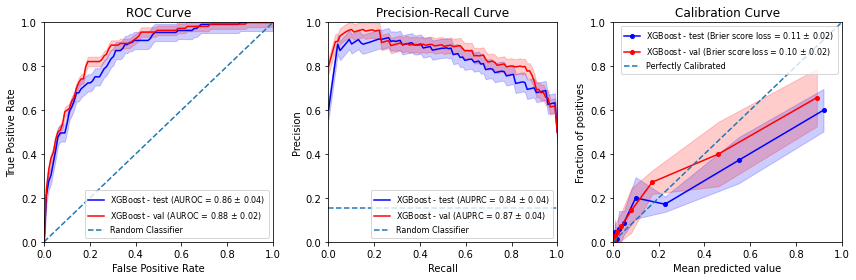

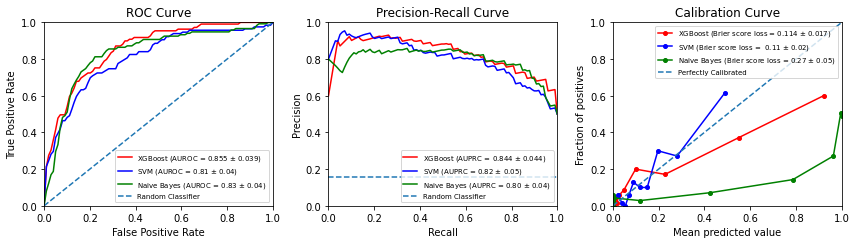

In [11]:
if __name__ == "__main__":
    main(subset_index = 2)

Processing: EMA
Fitting 5 folds for each of 48 candidates, totalling 240 fits


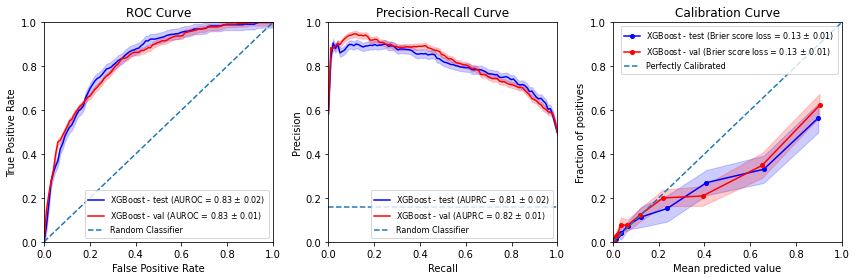

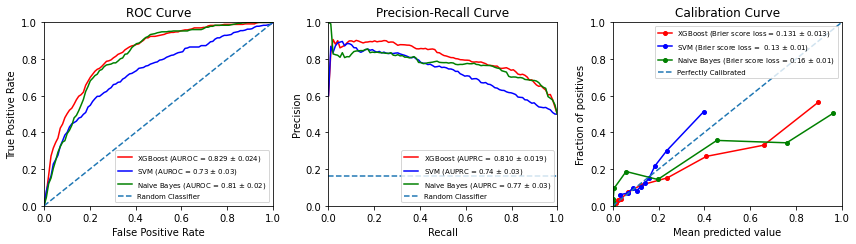

In [12]:
if __name__ == "__main__":
    main(subset_index = 1)

Processing: sensor
Fitting 5 folds for each of 48 candidates, totalling 240 fits


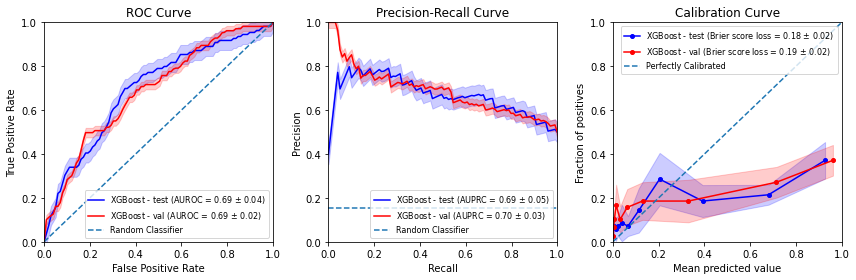

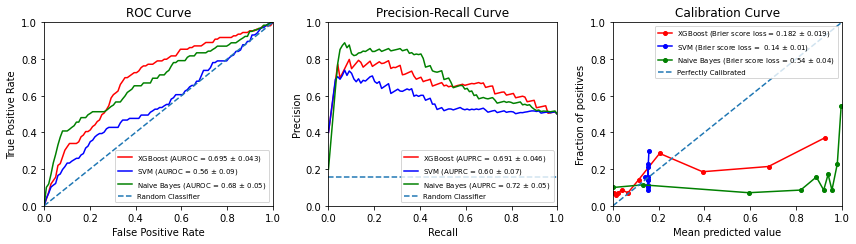

In [13]:
if __name__ == "__main__":
    main(subset_index = 0)